In [30]:
import sys
from pathlib import Path

ROOT = Path('/Users/raghavv/Desktop/pythonstuff/biol4559/project')
sys.path.insert(0, str(ROOT / 'bipartiteSBM'))
sys.path.insert(0, str(ROOT))

print('sys.path updated')

sys.path updated


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import polars as pl
import pandas as pd

In [ ]:
df = pl.read_csv("hosts.csv", encoding="utf8-lossy", ignore_errors=True, null_values=["NA", ""], infer_schema_length=0)

filtered_both = df.filter((pl.col("hOrder") == "PRIMATES") & (pl.col("hHostNameFinal") != "Homo_sapiens") | (pl.col("hOrder") == "RODENTIA")) #excluding humans cuz it's a huge outlier

print(filtered_both.select(["hHostNameFinal", "hOrder"]))

shape: (318, 2)
┌─────────────────────────┬──────────┐
│ hHostNameFinal          ┆ hOrder   │
│ ---                     ┆ ---      │
│ str                     ┆ str      │
╞═════════════════════════╪══════════╡
│ Abrothrix_longipilis    ┆ RODENTIA │
│ Abrothrix_olivaceus     ┆ RODENTIA │
│ Abrothrix_sanborni      ┆ RODENTIA │
│ Aethomys_kaiseri        ┆ RODENTIA │
│ Aethomys_namaquensis    ┆ RODENTIA │
│ …                       ┆ …        │
│ Vandeleuria_oleracea    ┆ RODENTIA │
│ Varecia_variegata       ┆ PRIMATES │
│ Xerus_erythropus        ┆ RODENTIA │
│ Xerus_inauris           ┆ RODENTIA │
│ Zygodontomys_brevicauda ┆ RODENTIA │
└─────────────────────────┴──────────┘


In [ ]:
df2 = df = pl.read_csv("associations.csv", encoding="utf8-lossy", ignore_errors=True, null_values=["NA", ""], infer_schema_length=0)


filtered_both_list = filtered_both["hHostNameFinal"].to_list()
df2_both = df2.filter(pl.col("hHostNameFinal").is_in(filtered_both_list))
df2_both = df2_both.join(filtered_both.select(["hHostNameFinal", "hOrder"]), on="hHostNameFinal", how="left")

filtered_df2_both = df2_both.select(["hHostNameFinal", "vVirusNameCorrected", "DetectionQuality"])


print(filtered_df2_both)

shape: (998, 3)
┌─────────────────────────┬─────────────────────────────────┬──────────────────┐
│ hHostNameFinal          ┆ vVirusNameCorrected             ┆ DetectionQuality │
│ ---                     ┆ ---                             ┆ ---              │
│ str                     ┆ str                             ┆ str              │
╞═════════════════════════╪═════════════════════════════════╪══════════════════╡
│ Abrothrix_longipilis    ┆ Andes_virus                     ┆ 2                │
│ Abrothrix_olivaceus     ┆ Andes_virus                     ┆ 0                │
│ Abrothrix_sanborni      ┆ Andes_virus                     ┆ 0                │
│ Aethomys_kaiseri        ┆ Witwatersrand_virus             ┆ 0                │
│ Aethomys_namaquensis    ┆ Crimean-Congo_hemorrhagic_feve… ┆ 0                │
│ …                       ┆ …                               ┆ …                │
│ Zygodontomys_brevicauda ┆ Guanarito_virus                 ┆ 2                │
│ Zygodontom

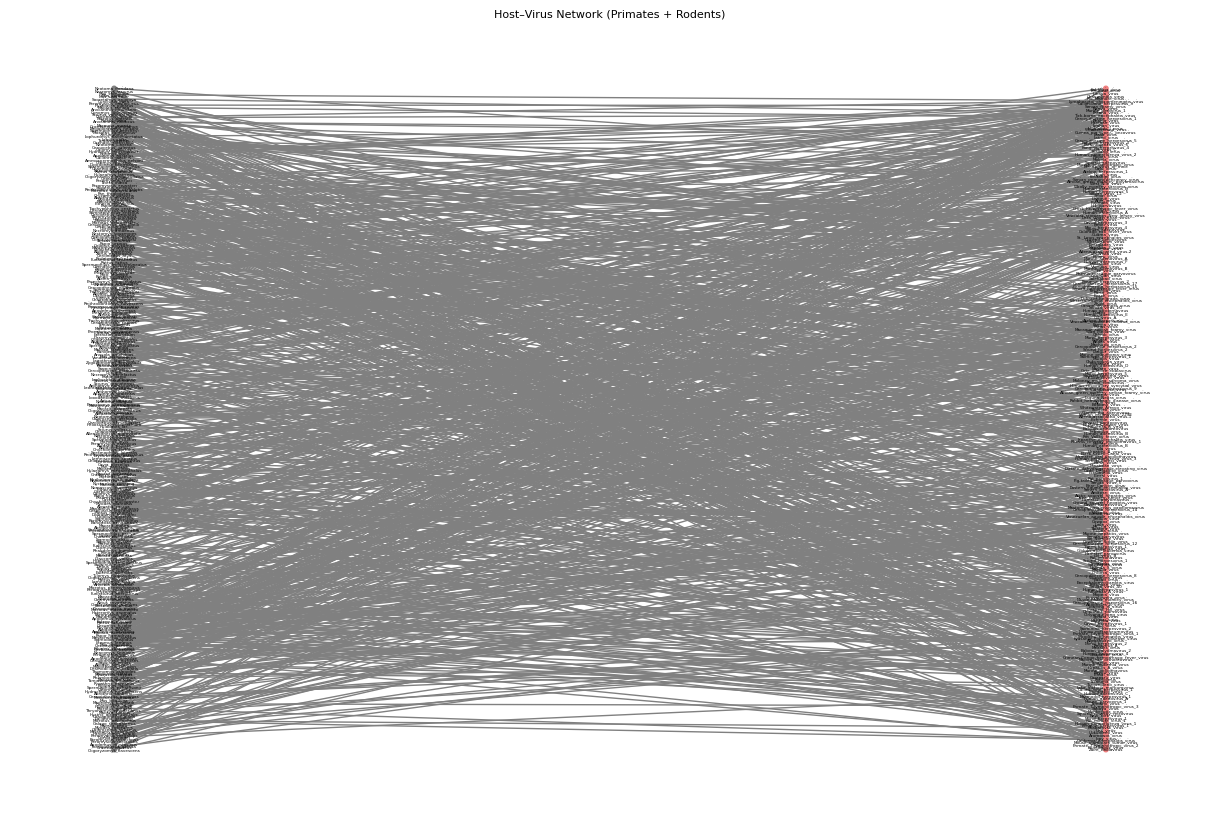

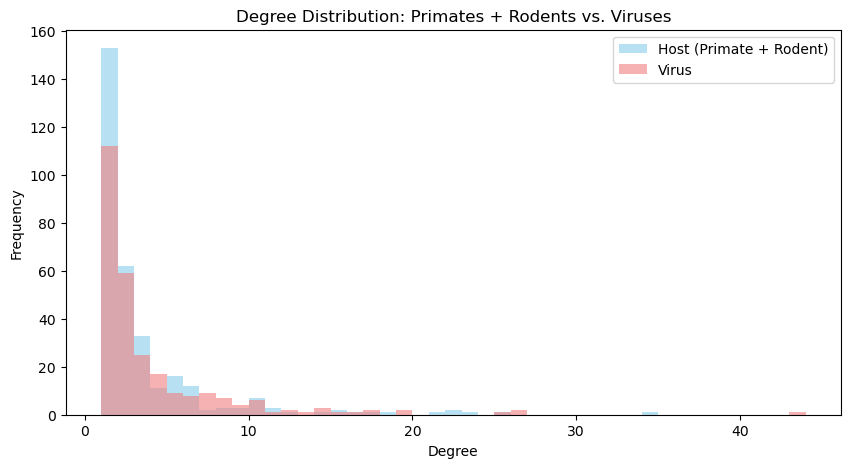

Top 10 Hosts (Primates + Rodents) by Degree:
Mus_musculus (RODENTIA): 34
Pan_troglodytes (PRIMATES): 25
Rattus_rattus (RODENTIA): 23
Macaca_mulatta (PRIMATES): 22
Sigmodon_hispidus (RODENTIA): 22
Rattus_norvegicus (RODENTIA): 21
Apodemus_sylvaticus (RODENTIA): 18
Macaca_fascicularis (PRIMATES): 17
Sciurus_carolinensis (RODENTIA): 16
Pongo_pygmaeus (PRIMATES): 15

Top 10 Viruses by Degree:
Simian_foamy_virus: 43
Encephalomyocarditis_virus: 26
Andes_virus: 26
St._Louis_encephalitis_virus: 25
Whitewater_Arroyo_virus: 19
Colorado_tick_fever_virus: 19
Vesicular_stomatitis_Indiana_virus: 17
Venezuelan_equine_encephalitis_virus: 17
Lymphocytic_choriomeningitis_virus: 16
Simian_immunodeficiency_virus: 15

Number of 3-paths: 50748
Number of 4-cycles: 1440
Clustering Coefficient: 0.11350200993142587


In [34]:
G_hostvirus = nx.Graph()
G_hostvirus.add_nodes_from(df2_both["hHostNameFinal"], bipartite=0)
G_hostvirus.add_nodes_from(df2_both["vVirusNameCorrected"], bipartite=1)

edge_list_hostvirus = df2_both.select(["hHostNameFinal", "vVirusNameCorrected"]).rows()
G_hostvirus.add_edges_from(edge_list_hostvirus)

hosts_both = df2_both["hHostNameFinal"].unique().to_list()
host_number = {name: i+1 for i, name in enumerate(hosts_both)}
viruses_both = df2_both["vVirusNameCorrected"].unique().to_list()
virus_number = {name: i+1+len(hosts_both) for i, name in enumerate(viruses_both)}


host_order_map = dict(zip(df2_both["hHostNameFinal"], df2_both["hOrder"]))

node_colors = []
for n in G_hostvirus.nodes():
    if n in host_order_map:
        order = host_order_map[n]
        if order == "PRIMATE":
            node_colors.append("skyblue")
        elif order == "RODENT":
            node_colors.append("lightgreen")
        else:
            node_colors.append("gray")
    else:
        node_colors.append("lightcoral")  # virus node

pos_hostvirus = nx.bipartite_layout(G_hostvirus, hosts_both)

plt.figure(figsize=(12, 8))
nx.draw(
    G_hostvirus,
    pos_hostvirus,
    with_labels=True,
    node_color=node_colors,
    node_size=10,
    edge_color="gray",
    font_size=3
)

plt.title("Host–Virus Network (Primates + Rodents)", fontsize=8, pad=1)
plt.show()

degree_dict_hv = dict(G_hostvirus.degree())
host_degrees_hv = [degree_dict_hv[n] for n in hosts_both]
virus_degrees_hv = [degree_dict_hv[n] for n in viruses_both]

plt.figure(figsize=(10, 5))
plt.hist(host_degrees_hv, bins=range(1, max(host_degrees_hv)+2), alpha=0.6, label="Host (Primate + Rodent)", color="skyblue")
plt.hist(virus_degrees_hv, bins=range(1, max(virus_degrees_hv)+2), alpha=0.6, label="Virus", color="lightcoral")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree Distribution: Primates + Rodents vs. Viruses")
plt.legend()
plt.show()

host_degrees = {n: degree_dict_hv[n] for n in hosts_both}
virus_degrees = {n: degree_dict_hv[n] for n in viruses_both}
sorted_hosts = sorted(host_degrees.items(), key=lambda x: x[1], reverse=True)
sorted_viruses = sorted(virus_degrees.items(), key=lambda x: x[1], reverse=True)

print("Top 10 Hosts (Primates + Rodents) by Degree:")
for n, d in sorted_hosts[:10]:
    order = host_order_map.get(n, "Unknown")
    print(f"{n} ({order}): {d}")

print("\nTop 10 Viruses by Degree:")
for n, d in sorted_viruses[:10]:
    print(f"{n}: {d}")

path3 = sum((degree_dict_hv[u]-1)*(degree_dict_hv[v]-1) for u, v in G_hostvirus.edges())
print("\nNumber of 3-paths:", path3)

from itertools import combinations

nbrs = {u: set(G_hostvirus.neighbors(u)) for u in hosts_both}
cycle4 = 0
for u1, u2 in combinations(hosts_both, 2):
    c = len(nbrs[u1] & nbrs[u2])
    cycle4 += c*(c-1)//2
print("Number of 4-cycles:", cycle4)

cc_hv = (4 * cycle4) / path3 if path3 > 0 else 0
print("Clustering Coefficient:", cc_hv)

In [ ]:
filtered_df2_both.select([
    pl.col("hHostNameFinal"),
    pl.col("vVirusNameCorrected")
]).write_csv("host_virus.edgelist", separator="\t", include_header=False)

import os
os.path.abspath("host_virus.edgelist")

df_edges = filtered_df2_both.select([
    pl.col("hHostNameFinal"),
    pl.col("vVirusNameCorrected")
])


hosts_df = (
    df_edges
    .select("hHostNameFinal")
    .unique()
    .with_row_index("host_id") 
)

n_hosts = hosts_df.height

virus_df = (
    df_edges
    .select("vVirusNameCorrected")
    .unique()
    .with_row_index("virus_id_og") 
    .with_columns(
        (pl.col("virus_id_og") + n_hosts).alias("virus_id")
    )
    .drop("virus_id_og")
)

numeric_edges = (
    df_edges
    .join(hosts_df, on="hHostNameFinal", how="left")
    .join(virus_df, on="vVirusNameCorrected", how="left")
    .select(["host_id", "virus_id"])
)

numeric_edges.write_csv(
    "host_virus_numeric.edgelist",
    separator="\t",
    include_header=False
)


numeric_edges.write_csv(
    "/Users/raghavv/Desktop/pythonstuff/biol4559/project/host_virus_numeric.edgelist",
    separator="\t",
    include_header=False
)

n_hosts = hosts_df.height
n_virus = virus_df.height
print(n_hosts, n_virus)



# Create types list
types = []

# Hosts: type 0
for i in range(n_hosts):
    types.append(f"{i} 0")

# Viruses: type 1
for j in range(n_virus):
    node_id = n_hosts + j
    types.append(f"{node_id} 1")

# Write to file
with open("host_virus.types", "w") as f:
    f.write("\n".join(types))

318 273


In [ ]:
import os
os.getcwd()

'/Users/raghavv/Desktop/pythonstuff/biol4559/project'

In [50]:
from biSBM.ioutils import get_edgelist
from biSBM.optimalks import *

from engines.mcmc import *
from engines.mcmc import MCMC

# Write types file in correct format FIRST
with open("/Users/raghavv/Desktop/pythonstuff/biol4559/project/host_virus.types", 'w') as f:
    for i in range(n_hosts):
        f.write(f"0\n")
    for j in range(n_virus):
        f.write(f"1\n")

# Use absolute path to binary
mcmc = MCMC(f_engine="/Users/raghavv/Desktop/pythonstuff/biol4559/project/bipartiteSBM/engines/bipartiteSBM-MCMC/bin/mcmc")
mcmc.prepare_engine(
    "/Users/raghavv/Desktop/pythonstuff/biol4559/project/host_virus_numeric.edgelist",
    n_hosts,
    n_virus,
    2,
    20
)

'/Users/raghavv/Desktop/pythonstuff/biol4559/project/bipartiteSBM/engines/bipartiteSBM-MCMC/bin/mcmc -e /Users/raghavv/Desktop/pythonstuff/biol4559/project/host_virus_numeric.edgelist -n 159 159 14 14 14 14 14 14 14 14 14 14 14 14 14 13 13 13 13 13 13 13 -t 100000 -x 2000 -c abrupt_cool -a 1000.0 -y 318 273 -z 2 20 -E 1.0 -g'

In [54]:
mcmc.prepare_engine("/Users/raghavv/Desktop/pythonstuff/biol4559/project/host_virus_numeric.edgelist", 318, 273, 2, 10)
edgelist = get_edgelist("/Users/raghavv/Desktop/pythonstuff/biol4559/project/host_virus_numeric.edgelist")

n1 = n_hosts
n2 = n_virus

types = get_types("/Users/raghavv/Desktop/pythonstuff/biol4559/project/host_virus.types")


types = mcmc.gen_types(n1, n2)
oks = OptimalKs(mcmc, edgelist, types)
oks.minimize_bisbm_dl()

(Ka, Kb) = (23, 22) 
entropy: 5203.48
(Ka, Kb) = (5, 4) 
entropy: 4728.16
(Ka, Kb) = (7, 6) 
entropy: 4709.08
(Ka, Kb) = (4, 3) 
entropy: 4750.86
(Ka, Kb) = (9, 8) 
entropy: 4736.49
(Ka, Kb) = (7, 5) 
entropy: 4732.7
(Ka, Kb) = (6, 4) 
entropy: 4708.23
(Ka, Kb) = (4, 4) 
entropy: 4697.1
(Ka, Kb) = (6, 6) 
entropy: 4712.64
(Ka, Kb) = (2, 2) 
entropy: 4716.99
(Ka, Kb) = (6, 2) 
entropy: 4788.02
(Ka, Kb) = (6, 5) 
entropy: 4739.22
(Ka, Kb) = (3, 6) 
entropy: 4731.16
(Ka, Kb) = (3, 2) 
entropy: 4791.51
(Ka, Kb) = (6, 3) 
entropy: 4736.01
(Ka, Kb) = (5, 3) 
entropy: 4714.7
(Ka, Kb) = (2, 6) 
entropy: 4764.55
(Ka, Kb) = (4, 5) 
entropy: 4708.74
(Ka, Kb) = (2, 3) 
entropy: 4724.82
(Ka, Kb) = (3, 4) 
entropy: 4711.3
(Ka, Kb) = (5, 2) 
entropy: 4771.04
(Ka, Kb) = (5, 5) 
entropy: 4698.68
(Ka, Kb) = (4, 2) 
entropy: 4767.31
(Ka, Kb) = (4, 6) 
entropy: 4716.8
(Ka, Kb) = (2, 5) 
entropy: 4799.25
(Ka, Kb) = (2, 4) 
entropy: 4749.54
(Ka, Kb) = (5, 6) 
entropy: 4716.34
(Ka, Kb) = (3, 5) 
entropy: 472

OrderedDict([((1, 1), 4813.018242010868),
             ((np.int64(23), np.int64(22)), 5203.480883966224),
             ((np.int64(5), np.int64(4)), 4728.156709896433),
             ((np.int64(7), np.int64(6)), 4709.081744556237),
             ((np.int64(4), np.int64(3)), 4750.856831890185),
             ((np.int64(9), np.int64(8)), 4736.487359244486),
             ((np.int64(7), np.int64(5)), 4732.696712849757),
             ((np.int64(6), np.int64(4)), 4708.231498054653),
             ((np.int64(4), np.int64(4)), 4697.102052952219),
             ((np.int64(6), np.int64(6)), 4712.640554050424),
             ((np.int64(2), np.int64(2)), 4716.993629340116),
             ((np.int64(6), np.int64(2)), 4788.01781143243),
             ((np.int64(6), np.int64(5)), 4739.21508536223),
             ((np.int64(3), np.int64(6)), 4731.160056341336),
             ((np.int64(3), np.int64(2)), 4791.505145109074),
             ((np.int64(6), np.int64(3)), 4736.01311898538),
             ((np.int64(5), n

In [ ]:
oks.summary()
labels = oks.bm_state["mb"]

labels

NameError: name 'n_a' is not defined